# Analyse de Sentiments - Critiques de Films

Ce notebook couvre l'intégralité du pipeline d'analyse de sentiments sur le dataset Allociné :
1.  **Collecte des données**
2.  **Prétraitement (Cleaning & Lemmatisation)**
3.  **Analyse Exploratoire (EDA)**
4.  **Modélisation (Naive Bayes, SVM, Random Forest)**
5.  **Évaluation**
6.  **Interprétation**

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
import spacy
import re
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import tqdm

# Configuration visuelle
sns.set(style="whitegrid")
%matplotlib inline

## 1. Collecte des données
Récupération du dataset `allocine` via Hugging Face.

In [13]:
print("Chargement du dataset Allociné...")
try:
    # On essaie de charger localement si déjà téléchargé par le script précédent
    df = pd.read_csv("allocine_raw.csv")
    print("Données chargées depuis allocine_raw.csv")
except FileNotFoundError:
    dataset = load_dataset("allocine")
    train_df = pd.DataFrame(dataset['train'])
    val_df = pd.DataFrame(dataset['validation'])
    test_df = pd.DataFrame(dataset['test'])
    df = pd.concat([train_df, val_df, test_df], ignore_index=True)
    # Sauvegarde pour la prochaine fois
    df = df[['review', 'label']]
    df.to_csv("allocine_raw.csv", index=False)
    print("Données téléchargées et sauvegardées.")

print(f"Nombre total d'avis : {len(df)}")
print(df.head())

Chargement du dataset Allociné...
Données chargées depuis allocine_raw.csv
Nombre total d'avis : 200000
                                              review  label
0  Si vous cherchez du cinéma abrutissant à tous ...      0
1  Trash, re-trash et re-re-trash...! Une horreur...      0
2  Et si, dans les 5 premières minutes du film, l...      0
3  Mon dieu ! Quelle métaphore filée ! Je suis ab...      0
4  Premier film de la saga Kozure Okami, "Le Sabr...      1


## 2. Prétraitement (Cleaning)
Objectifs :
- Minuscules
- Retrait HTML
- Gestion Emojis
- Lemmatisation avec SpaCy

In [4]:
# Chargement de SpaCy
try:
    nlp = spacy.load("fr_core_news_sm")
except OSError:
    print("Modèle non trouvé, téléchargement...")
    from spacy.cli import download
    download("fr_core_news_sm")
    nlp = spacy.load("fr_core_news_sm")

EMOJI_MAPPING = {
    "🤩": "génial", "😍": "adoré", "❤️": "amour", "👍": "bien", 
    "👎": "nul", "😡": "colère", "😂": "rire", "😭": "triste", 
    "🤢": "dégoût", "🤮": "horrible", "👏": "bravo", "🔥": "feu", 
    "✨": "brillant", "💀": "mort", "💩": "merde"
}

def clean_text(text):
    if not isinstance(text, str): return ""
    # Emojis
    for emoji_char, text_replacement in EMOJI_MAPPING.items():
        text = text.replace(emoji_char, f" {text_replacement} ")
    # HTML
    text = re.sub(r'<[^>]+>', ' ', text)
    # Minuscules et espaces superflus
    text = text.lower().strip()
    return text

print("Nettoyage initial...")
df['cleaned_review'] = df['review'].apply(clean_text)

# Pour l'exercice, si le dataset est très grand, on lemmatise un échantillon 
# pour que l'exécution ne prenne pas des heures (Optionnel: retirer .sample() pour tout faire)
if len(df) > 5000:
    print("Sous-échantillonnage à 5000 avis pour la rapidité du notebook (Dataset complet dispo).")
    df_sample = df.sample(5000, random_state=42).copy()
else:
    df_sample = df.copy()

print("Lemmatisation avec SpaCy...")
docs = list(nlp.pipe(df_sample['cleaned_review'], batch_size=50, disable=['ner', 'parser']))
df_sample['lemmatized'] = [" ".join([t.lemma_ for t in doc if not t.is_punct and not t.is_space]) for doc in docs]

print(df_sample[['cleaned_review', 'lemmatized']].head())

                                           cleaned_review  \
119737  vu aujourd'hui (merci l'offre temporaire d'acc...   
72272   critique man of steel: une nouvelle version du...   
158154  la citadelle assiégée, c'est un documentaire s...   
65426   film peu connu et qui mérite de le rester : sc...   
30074   il faut savoir que le script de ce film possèd...   

                                               lemmatized  
119737  voir aujourd'hui merci le offre temporaire de ...  
72272   critique man of steel un nouveau version de cé...  
158154  le citadelle assiégé ce être un documentaire s...  
65426   film peu connaître et qui mérite de le rester ...  
30074   il falloir savoir que le script de ce film pos...  


## 3. Analyse Exploratoire (EDA)
- Wordclouds (Positif vs Négatif)
- Distribution des longueurs

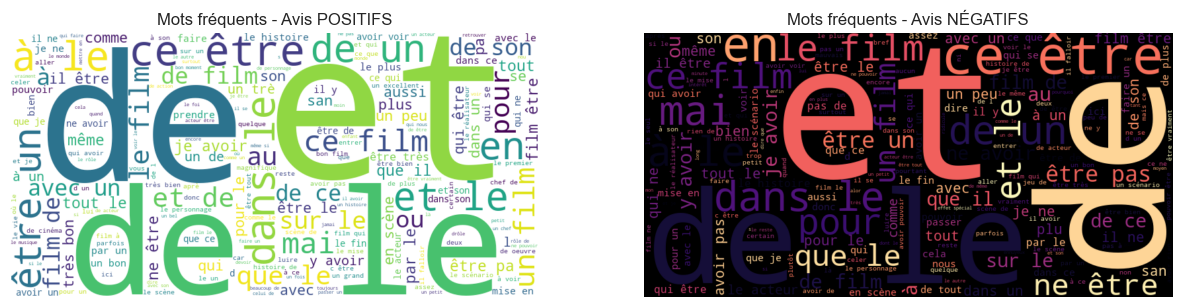

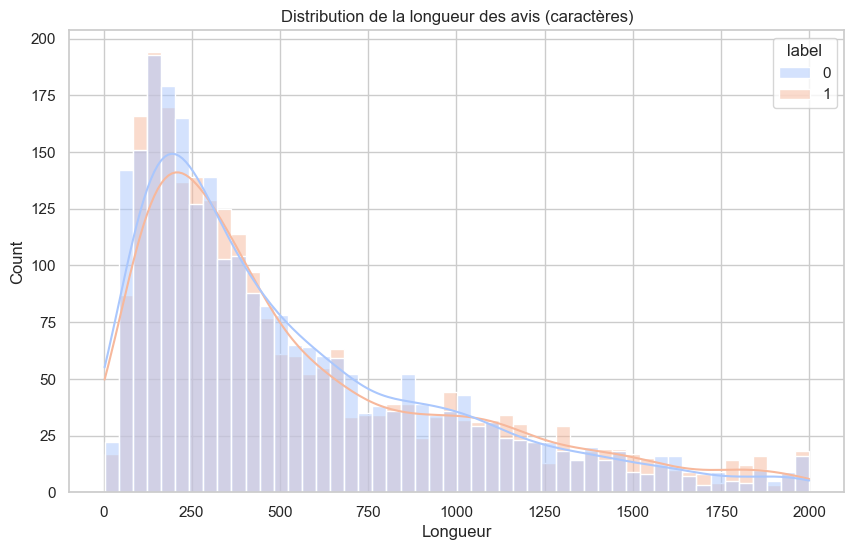

In [5]:
# Séparation par label (0: Négatif, 1: Positif chez Allociné)
pos_reviews = df_sample[df_sample['label'] == 1]['lemmatized'].str.cat(sep=' ')
neg_reviews = df_sample[df_sample['label'] == 0]['lemmatized'].str.cat(sep=' ')

# Wordclouds
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
wc_pos = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(pos_reviews)
plt.imshow(wc_pos, interpolation='bilinear')
plt.title("Mots fréquents - Avis POSITIFS")
plt.axis('off')

plt.subplot(1, 2, 2)
wc_neg = WordCloud(width=800, height=400, background_color='black', colormap='magma').generate(neg_reviews)
plt.imshow(wc_neg, interpolation='bilinear')
plt.title("Mots fréquents - Avis NÉGATIFS")
plt.axis('off')

plt.show()

# Histogramme des longueurs
df_sample['length'] = df_sample['cleaned_review'].apply(len)

plt.figure(figsize=(10, 6))
sns.histplot(data=df_sample, x='length', hue='label', bins=50, kde=True, palette='coolwarm')
plt.title("Distribution de la longueur des avis (caractères)")
plt.xlabel("Longueur")
plt.show()

## 4. Modélisation
Comparaison de 3 modèles : Naive Bayes, SVM (LinearSVC), Random Forest.

In [6]:
# Vectorisation TF-IDF
vectorizer = TfidfVectorizer(max_features=5000, min_df=5, max_df=0.9)
X = vectorizer.fit_transform(df_sample['lemmatized'])
y = df_sample['label']

# Split Train/Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    "Naive Bayes": MultinomialNB(),
    "SVM Linéaire": LinearSVC(dual='auto', random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}

results = {}

for name, model in models.items():
    print(f"Entraînement de {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    results[name] = {"model": model, "f1": f1, "pred": y_pred}
    print(f"F1-Score ({name}) : {f1:.4f}")

Entraînement de Naive Bayes...
F1-Score (Naive Bayes) : 0.8733
Entraînement de SVM Linéaire...
F1-Score (SVM Linéaire) : 0.8734
Entraînement de Random Forest...
F1-Score (Random Forest) : 0.8257


## 5. Évaluation
Détail des performances pour le meilleur modèle.

Meilleur modèle : SVM Linéaire

Rapport de classification :
              precision    recall  f1-score   support

           0       0.87      0.88      0.88       503
           1       0.88      0.87      0.87       497

    accuracy                           0.88      1000
   macro avg       0.88      0.87      0.87      1000
weighted avg       0.88      0.88      0.87      1000



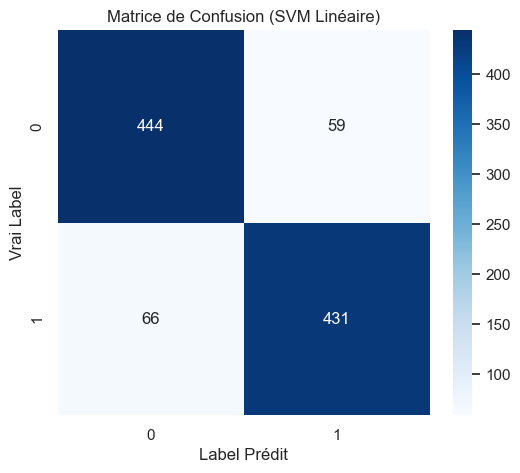

In [7]:
best_model_name = max(results, key=lambda k: results[k]['f1'])
print(f"Meilleur modèle : {best_model_name}")

y_pred_best = results[best_model_name]['pred']

print("\nRapport de classification :")
print(classification_report(y_test, y_pred_best))

conf_mat = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.title(f"Matrice de Confusion ({best_model_name})")
plt.ylabel('Vrai Label')
plt.xlabel('Label Prédit')
plt.show()

## 6. Interprétation et Discussion
Analyse des mots les plus influents (coefficients) pour le modèle linéaire (SVM ou RegLog).

In [8]:
# Si le SVM est le meilleur ou disponible, on regarde ses coefs
item_model = results.get("SVM Linéaire", {}).get("model")
if item_model:
    feature_names = vectorizer.get_feature_names_out()
    coefs = item_model.coef_[0]
    
    # Top 10 mots positifs et négatifs
    top_pos_indices = coefs.argsort()[-10:][::-1]
    top_neg_indices = coefs.argsort()[:10]
    
    print("Top 10 mots influençant le POSITIF :")
    print([feature_names[i] for i in top_pos_indices])
    
    print("\nTop 10 mots influençant le NÉGATIF :")
    print([feature_names[i] for i in top_neg_indices])
else:
    print("Le SVM n'a pas été entraîné, impossible d'extraire les coefficients simplement.")

Top 10 mots influençant le POSITIF :
['excellent', 'magnifique', 'adorer', 'génial', 'bon', 'bravo', 'bonheur', 'chef', 'remarquable', 'beau']

Top 10 mots influençant le NÉGATIF :
['rien', 'mauvais', 'ennuyeux', 'intérêt', 'navet', 'moyen', 'décevant', 'nul', 'lent', 'heureusement']


### Discussion des limites
- **Ironie/Sarcasme** : Les modèles Bag-of-Words (comme TF-IDF) perdent l'ordre des mots et peinent à détecter l'ironie ("Quel chef d'oeuvre... je me suis endormi").
- **Contexte** : "Pas mal" vs "Vraiment mal". La négation est difficile à capter sans n-grams ou modèles contextuels.
- **Amélioration possible** : Utiliser BERT (Transformers) qui capte le contexte bidirectionnel.

## 7. Bonus : Deep Learning avec CamemBERT
Utilisation d'un modèle Transformer pré-entraîné pour le français.

In [9]:
# Installation des dépendances pour le Deep Learning
# Exécutez cette cellule pour installer torch et transformers dans l'environnement du notebook
%pip install torch transformers sentencepiece


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [14]:
import torch
from transformers import CamembertTokenizer, CamembertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset

# Vérification GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device : {device}")

# Chargement Tokenizer
tokenizer = CamembertTokenizer.from_pretrained("camembert-base")

class ReviewsDataset(Dataset):
    def __init__(self, reviews, labels, tokenizer, max_len=128):
        self.reviews = reviews
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, item):
        review = str(self.reviews[item])
        label = self.labels[item]
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Préparation des datasets PyTorch
# On utilise les textes bruts (ou légèrement nettoyés) pour BERT, il gère bien le contexte
# On réduit la taille pour la rapidité si pas de GPU
if device.type == 'cpu':
    print("Attention : Entraînement sur CPU. Utilisation d'un sous-ensemble réduit (200 avis) pour la démo.")
    sample_size = 200
else:
    sample_size = 2000 # Plus grand si GPU

df_bert = df.sample(sample_size, random_state=42)
X_train_bert, X_test_bert, y_train_bert, y_test_bert = train_test_split(df_bert['review'], df_bert['label'], test_size=0.2)

train_dataset = ReviewsDataset(X_train_bert.to_numpy(), y_train_bert.to_numpy(), tokenizer)
test_dataset = ReviewsDataset(X_test_bert.to_numpy(), y_test_bert.to_numpy(), tokenizer)

print("Datasets prêts.")

Device : cpu
Attention : Entraînement sur CPU. Utilisation d'un sous-ensemble réduit (200 avis) pour la démo.
Datasets prêts.


In [1]:
# Chargement du modèle
model = CamembertForSequenceClassification.from_pretrained("camembert-base", num_labels=2)
model.to(device)

# Configuration de l'entraînement
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=2,              # Peu d'époques pour la démo
    per_device_train_batch_size=8 if device.type == 'cpu' else 16,
    per_device_eval_batch_size=16,
    warmup_steps=10,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    eval_strategy="epoch"
)

from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    return {
        'accuracy': accuracy_score(labels, preds),
        'f1': f1,
        'precision': precision
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

print("Début de l'entraînement CamemBERT...")
trainer.train()

NameError: name 'CamembertForSequenceClassification' is not defined

In [ ]:
# Évaluation finale BERT
results_bert = trainer.evaluate()
print("Résultats CamemBERT :")
print(results_bert)